# Deep Learning Tutorial

In this notebook, we are going to apply recurrent neural networks to text classification problem in order to predict in which forum on Stackexchnage the question was asked.

Please note: 

- You can interrupt the training process at any time by clicking on *Kernel* and then *Interrupt*.
- This notebook has not yet been adapted to Keras 2. If you use Python and don't want to use AWS, please do: `conda install keras==1.1.1 graphviz pydot`

We will be using the [Keras](http://keras.io) framework that abstracts away a lot of the details of deep learning. We will only use the [funcational API](https://keras.io/getting-started/functional-api-guide/) due to its expressive power.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

from keras.models import Model
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import *
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Using Theano backend.


## Loading data

Data has been already preprocessed from raw XML format and saved to csv. However, you must remeber that Keras works on numpy arrays so we will prepare data before feed it to the network.

In [2]:
df_final = pd.read_csv("dataset_final.csv", sep=',')

First, let's focus on columns with questions!

In [3]:
df_final['question'][1]

'I am trying to model the effect of advertisement on sales in Stata. The data is weekly and there are around 150 observations. I started by applying an ARMAX(1,0,1) model with the following exogenous variables: investment in advertisement, quantities bought by visit and some seasonal dummies (Q1, Q2, Q3).  \n\nI would like to have some ideas regarding the model:\n\n<ol>\n<li>Is this the best model to estimate the coefficients accurately?</li>\n<li>Should I be worried about endogeneity?</li>\n<li>Is there any way to impose (or test) diminishing returns for the investment in advertisement?</li>\n</ol>\n'

In [4]:
Y = np.array(df_final['forum'])
X = df_final.drop('forum', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Tokenization

Now that we have splitted data to train and test let's finally preprocess question column. Remember that you cannot just input words-they must be in numerical form. Keras has a lot of [methods](https://keras.io/preprocessing/text/#tokenizer) to tackle that issue.

In this tutorial, we use a tokenizer that splits sentences into words in form of indices in a word dictionary.

In [5]:
tokenizer = Tokenizer()

Fit tokenizer on training data (build the vocabulary of words):

In [6]:
tokenizer.fit_on_texts(list(X_train['question'].values))

And look up the word indices in the tokenizer model for our data:

In [7]:
X_train_tokenized = tokenizer.texts_to_sequences(list(X_train['question'].values))
X_test_tokenized = tokenizer.texts_to_sequences(list(X_test['question'].values))

## Padding

Because we will be training in mini-baches that need to fit into a numpy array, we need our sentences to have the same number of words. We can achieve this by a method called padding. Padding simply fills up our sentences (list of word indices) with zeros until there are at least `maxlen` words in the sentence.

In [8]:
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=150)
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=150)

Let's inspect what padding did to our data. We can see that before padding, we had 70 words in sentence 155:

In [9]:
len(X_train_tokenized[155])

70

After padding, we have exactly 150:

In [10]:
X_train_padded[155].shape

(150,)

And the missing words were filled up with zeros:

In [11]:
X_train_padded[155]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     9,
         239,   430,    41,    23,   323,   334,    77,   174,   112,
         140,   698,   235,    13,    17,     1,   179,   342,   356,
           4,  1027,  2083,    15,   152,     2,    50,    33,   136,
         162,   356,    11,     1,  2097,   334,     6,    41,     3,
        1806,     5,  1584,   179,   342,    11,    55,  2097,   169,
          30,     6,

As the last step, do not forget to turn the target columns into an one-hot encoded array.

In [12]:
le = LabelEncoder()

Y_train = np.eye(3)[le.fit_transform(y_train).reshape(-1)]
Y_test = np.eye(3)[le.transform(y_test).reshape(-1)]

## Modelling our first network

Now let's inspect data that we obtained. Figuring out right shapes is crucial.

In this dataset we have...

In [13]:
timesteps = X_train_padded.shape[1]

In [14]:
timesteps

150

First, we define the input layer, which just takes in our data. It does not contain any logic other than defining the shape of our input. Since we use the functional API, this also means that all matrix shapes in the following layers will be inferred automatically.

In [15]:
input = Input(shape=(timesteps, ), name="inputs")

To model words we use an `Embedding` layer.

The embedding layer turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]. The first parameter defines how many words are in the dictionary, the second parameter defines the size of the vector the input is reduced to.

Skip-gram, CBOW, and GloVe (or any other word2vec variant) are pre-trained word embeddings which can be set as the weight of an embedding layer. If the weight of this layer (generally the first layer of the network) is not initialized by these pre-trained vectors, the model/network itself would assign random weights and will learn the embeddings (i.e. weights) on the fly.

In [16]:
x = Embedding(len(tokenizer.word_index)+1, 32, mask_zero=True)(input) # +1 for the vocabulary sign

Now, the fun parts starts. We will add an LSTM layer that builds a representation of each posted question based on the words in the sentence.

Remember the unfolding in time computation graph for an RNN

![image](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg)

where $x_t$ are words in particular question, e.g. $x_1$ is the first word and $x_2$ is the second word. In our case, we are only interested in the last output $o_t$ where $t$ corresponds to the last word.

In [17]:
x = LSTM(10)(x)

We're almost done! Let's wire up the 10 output neurons of the LSTM to 3 output neurons using a [Dense](https://keras.io/layers/core/#dense) layer (because we have 3 output classes). A Dense layer is just your regular fully connected NN layer. The softmax activation function squeezes these 3 numbers such that they sum up to one.

In [18]:
output = Dense(3, activation='softmax', name='output')(x)

Let's wrap up the input and output of our Model.

In [19]:
model = Model(input=input, output=output)

Now, we will compile our model. Here, we specify two parameters:

- optimizer: an optimizer does all the work for us. Given the input and the computed errors, it decides which direction to take. There are quite a few [optimizers available in Keras](https://keras.io/optimizers/).
- loss: the loss or objective function tells the model how well we are doing on our data. In our case, this is simply categorical crossentropy, but in other cases this may be e.g. mean squared error or binary crossentropy. Note that this function needs to be differentiable because during training we need to be able to compute the weight updates. Hence, we cannot optimize for e.g. ROCAUC directly.

In [20]:
model.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=['accuracy'])

Let's print out a nice plot of our model.

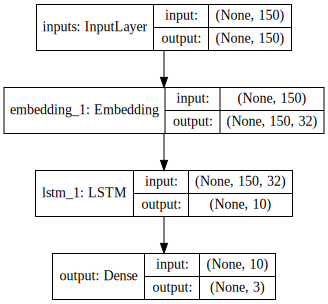

In [21]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Note that *None* simply means that the model does not really care how many instances we input.

## Let's train!

We train using a mini-batch size of 50 instances at a time. This speeds up things, because a mini-batch can be computed in parallel on a GPU. We train for eight epochs, i.e. we go over our training set three times.

In [ ]:
bs = 50

**Please leave *verbose* at 2** in the following call, otherwise your notebook may freeze.

In [ ]:
model.summary()
model.fit(X_train_padded, Y_train, verbose=2, nb_epoch=4, batch_size=bs, validation_data=(X_test_padded, Y_test))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inputs (InputLayer)              (None, 150)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 150, 32)       1716704     inputs[0][0]                     
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10)            1720        embedding_1[0][0]                
____________________________________________________________________________________________________
output (Dense)                   (None, 3)             33          lstm_1[0][0]                     
Total params: 1718457
_____________________________________________________________________

## Task 1: Increase the number of neurons

Maybe the model is simply to small to accomodate patterns in our data? Let's try to increase our neurons!

**Your task** is to:

- Mark this chunk and select *Cell* and then *Run All Above*
- Increase the number of neurons to 20

In [ ]:
input = Input(shape=(timesteps,), name="inputs")
x = input

### Your code here
x = Embedding(len(tokenizer.word_index)+1, 32, mask_zero=True)(x)
x = LSTM(20)(x)
###

output = Dense(3, activation='softmax', name='output')(x)
model1 = Model(input=input, output=output)
model.summary()
model1.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model1.fit(X_train_padded, Y_train, verbose=2, nb_epoch=4, batch_size=bs, validation_data=(X_test_padded, Y_test))

## Task 2: Use Bidirectional layer

Let's make our model deeper! This is deep learning after all. Note that our network is already deep in time, i.e. we take into consideration 150 time steps. But we can also make it deeper vertically.

Your task is to

- instead of LSTM use Bidirectional LSTM layer with 20 neurons

- Next, add another bidirectional LSTM layer.
At each time step, the first LSTM will feed into the second LSTM. This is called stacking.

Note that for this, you have to set *return_sequences=True* in the first LSTM. Do you understand why this is required?

In [ ]:
input = Input(shape=(timesteps,), name="inputs")
x = input

### Your code goes here:
x = Embedding(len(tokenizer.word_index)+1, 32, mask_zero=True)(x)
x = Bidirectional(LSTM(20, return_sequences=True))(x)
x = Bidirectional(LSTM(20))(x)
##

output = Dense(3, activation='softmax', name='output')(x)
model2 = Model(input=input, output=output)
model2.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model2.fit(X_train_padded, Y_train, verbose=2, nb_epoch=4, batch_size=bs, validation_data=(X_test_padded, Y_test))

## Task 3: Add regularization

There are two major ways by which you can regularize model and descrease overfitting.

1. Dropout-it randomly sets a fraction *rate* of input units to 0 at each update during training time
2. L2 regularizer


Your task is to add dropout to the Model. Dropout is just another layer you can add to your model definition.

In [ ]:
input = Input(shape=(timesteps,), name="inputs")
x = input

### Your code goes here:
x = Embedding(len(tokenizer.word_index)+1, 32, mask_zero=True)(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(20, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(20))(x)
x = Dropout(0.5)(x)
##

output = Dense(3, activation='softmax', name='output')(x)
model3 = Model(input=input, output=output)
model3.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model3.fit(X_train_padded, Y_train, verbose=2, nb_epoch=4, batch_size=bs, validation_data=(X_test_padded, Y_test))

## Task 4: Feature Merging

This task will be a bit more challenging. We are going to use an additional attribute: tags on forum. However, because this attribute is constant we will not add it to LSTM that summarizes the time series.

Instead, we will *merge* the $n$-dimensional vector output of the LSTM with a $m$-dimensional vector, where merging means concatenating the two vectors into a vector of dimensionality $n+m$.

Conveniently, we have already encoded tags as a one-hot vector, i.e. the columns in the following matrix correspond to unique tags. Note that matrix is very sparse.

In [ ]:
tags_train = np.array(X_train.drop('question', axis=1))
tags_test = np.array(X_test.drop('question', axis=1))

In this task, you have to do the following:

- Use the solution from the previous task.
- Create a second Input with shape `(number_of_tags, )`.
- Introduce a [Merge](https://keras.io/getting-started/sequential-model-guide/#the-merge-layer) layer that merges `[x, your_new_input]`. This can be done using the `merge` **function** (not the `Merge` class).
- Modify the `Model` instantiation to take two inputs simultaneously, similar to what you have done in the previous step.

Note that you have to implement all of the above tasks before your model actually works.

In [ ]:
input = Input(shape=(timesteps,), name="inputs")

### Your code here
number_of_tags = tags_train.shape[1]
input2 = Input(shape=(number_of_tags,), name='inputs2')

x = Embedding(len(tokenizer.word_index)+1, 32)(input)
x = LSTM(20)(x)
x = Merge([x, input2], mode="concat")

###

output = Dense(3, activation='softmax', name='output')(x)
model4 = Model(input=[input, input2], output=output)
model4.compile(optimizer=Nadam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
SVG(model_to_dot(model3, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model4.fit([X_train_padded, tags_train], Y_train, verbose=2, nb_epoch=4, batch_size=bs, validation_split=([X_test_padded, tags_test], Y_test))

It's still getting better! This concludes the second deep learning tutorial.

If you still have some free time, you are welcome to experiment further with our architecture. Things you may want to try:

- Use GRU instead of LSTM units
- Change the number of neurons in the LSTM